In [1]:
%reset
import numpy as np
import sys
from scipy.integrate import trapz, simps
from IPython.display import clear_output
import matplotlib.pyplot as plt
%run constants.ipynb

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
sys.path.append('/home/anni/Work/photospheric_code/photospheric_modeling/')

In [3]:
from core import SimulationManager

In [4]:
def calculate_grid_parameters(xmin, xmax, ulim_lastbin):
    D_X = np.log(1/(1-ulim_lastbin/xmax))
    X_I = np.log(xmin)/D_X
    BIN_X = np.log(xmax)/D_X - X_I
    return D_X, int(X_I), int(BIN_X)

In [5]:
def calculate_grid_parameters_DX(xmin, xmax, D_X):
    X_I = np.log(xmin)/D_X
    BIN_X = np.log(xmax)/D_X - X_I
    return int(X_I), int(BIN_X)

In [6]:
D_X = 2.e-3
xmin = 1.e-5
xmax = 1.e0
X_I, BIN_X = calculate_grid_parameters_DX(xmin, xmax, D_X)
print(D_X, X_I, BIN_X)
delta_t = 1.e-4

0.002 -5756 5756


In [7]:
grid_parameters = {'BIN_X':BIN_X, 'D_X':D_X, 'X_I':X_I, 'type_grid' : 'log'}
solver_settings = {'include_kompaneets': True, 'kompaneets_extended_by': 'frequency', 'CN_solver': False }

In [8]:
sim = SimulationManager(grid_parameters, delta_t, solver_settings)

In [9]:
initial_array = np.zeros(BIN_X)

In [36]:
T = 1.e2/ k_B_eV

In [37]:
sim.source_parameters['T'] = T *k_B_erg/ m_e/c0**2
sim.source_parameters['n_e'] =2.e16


In [12]:
sim.delta_t = 1.e-4

In [13]:
energygrid = sim.energygrid

In [14]:
def PlanckDistributionGamma(Gamma, Temperature):
    res =0
    Energy = Gamma* m_e*c0**2
    lgr= Energy/(k_B_erg*Temperature)
    fac = 8. *np.pi/(c0*h)**3
    fac = 1.
    expo= (np.exp(lgr)-1)
    if not lgr < 1.e-10 or lgr > 1.e10: res = 1/expo*fac
    return res

In [15]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [16]:
idx = find_nearest(sim.energygrid, 10.e3/(511.e3))

In [17]:
def gaussian(x, width, midpoint):
    res = 1/(width*np.sqrt(np.pi*2))*np.exp(-0.5*((x - midpoint)/width)**2)
    return res

In [18]:
midpoint = idx
width = 30 # gridpoints, not energy
for i in range(BIN_X):
    initial_array[i] = 1.e-3*gaussian(i, width, midpoint)


In [19]:
sim.initialise_run(initial_array)

In [20]:
modules = []
#modules = []

sim.reset_modules(modules)

In [21]:
arr_to_integrate = sim.energygrid**3*sim.photonarray
E_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *simps(arr_to_integrate, sim.energygrid)
print(E_photons)

arr_to_integrate = sim.energygrid**2*sim.photonarray
N_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *simps(arr_to_integrate, sim.energygrid)
sim.N = N_photons

434515335385.3242


In [22]:
E_ele = 3/2 * T *k_B_erg*sim.source_parameters['n_e']
print(E_ele)

4806529.9020809755


In [23]:
Etot = E_ele + E_photons

In [24]:
old_photons = []

In [25]:
for j in range(8):
    for k in range(1000):
        arr_to_integrate = sim.energygrid**3*sim.photonarray
        E_photons_curr = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *simps(arr_to_integrate, sim.energygrid)
        clear_output(wait=True)
        sim.evolve_one_timestep()
        old_photons.append(sim.photonarray)

In [27]:
arr_to_integrate = sim.energygrid**3*sim.photonarray
E_photons = 8* np.pi * (m_e*c0**2)**4/(c0*h)**3 *trapz(arr_to_integrate, sim.energygrid)
print(E_photons)
E_ele = 3/2 * sim.source_parameters['T'] * k_B_erg*sim.source_parameters['n_e']
print(E_ele)


60083882681.59752
0.000810558808408681


In [28]:
import seaborn as sns

In [41]:
colors = sns.color_palette('BuPu', int(len(old_photons)/1))
norm2 = matplotlib.colors.Normalize(vmin=0, vmax=sim.time/1)

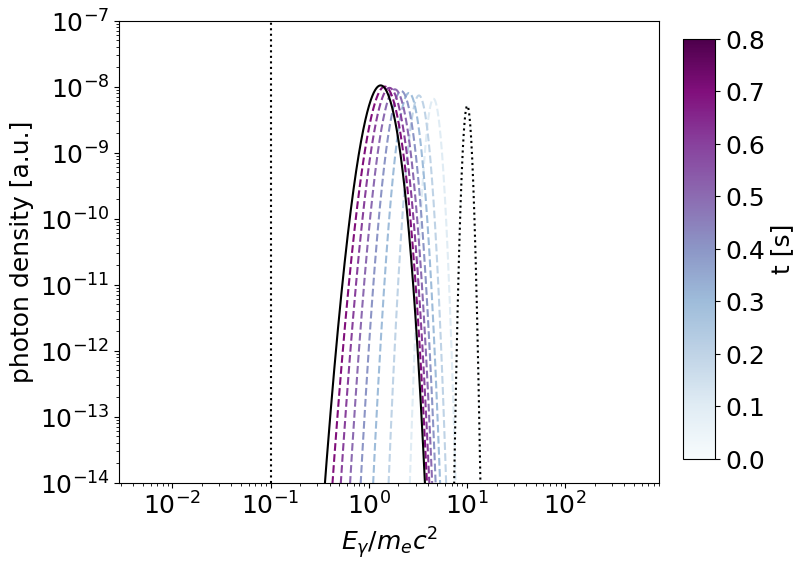

In [42]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

fig = plt.figure(figsize = [8, 6])

ax = plt.gca()

for k in range(8):
    k *= 1000
    ax.plot(sim.energygrid*511, old_photons[k]*sim.energygrid**2,
             ls = '--', c = colors[k])
    
    
    
    
ax.plot(sim.energygrid*511, sim.photonarray*sim.energygrid**2, color = 'k')
ax.plot(sim.energygrid*511, initial_array*sim.energygrid**2, ls = ':', color = 'k')
ax.axvline(sim.source_parameters['T']*511, color = 'k', ls = ':')
#ax.set(yscale = 'log', xscale = 'log', 
ax.set(      xlabel =r'$E_{\gamma}/ m_e c^2$',
      ylabel = 'photon density [a.u.]')
#plt.savefig('example_downscattering.png', dpi = 300)
ax.set(yscale = 'log', xscale = 'log', ylim = [1.e-14, 1.e-7])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.04, 0.7])
matplotlib.colorbar.ColorbarBase(cbar_ax, cmap='BuPu', norm = norm2, label = 't [s]')

plt.show()

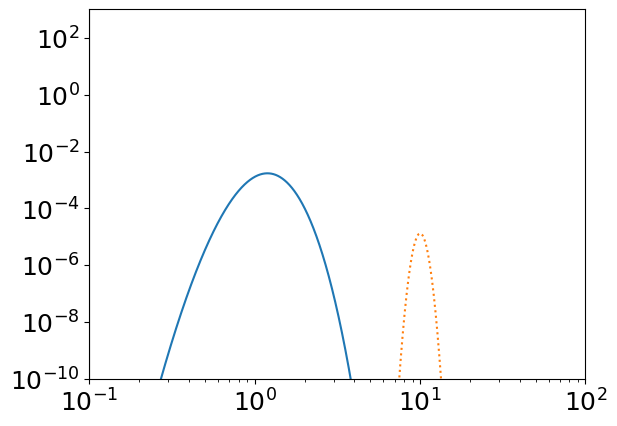

In [32]:
fig = plt.figure()
plt.plot(sim.energygrid*511, sim.photonarray)
#plt.plot(sim.energygrid*511, old_photons[4], ls = '--')

plt.plot(sim.energygrid*511, initial_array, ls = ':')

ax = plt.gca()
ax.axvline(sim.source_parameters['T']*511, color = 'k')
ax.set(yscale = 'log', xscale = 'log', 
       xlim = [1.e-1, 1.e2], ylim = [1.e-10, 1.e3])

#ax.set(yscale = 'log', xscale = 'log', xlim = [1.e-12, 1.e3], ylim = [1.e-14, 1.e3])
plt.show()

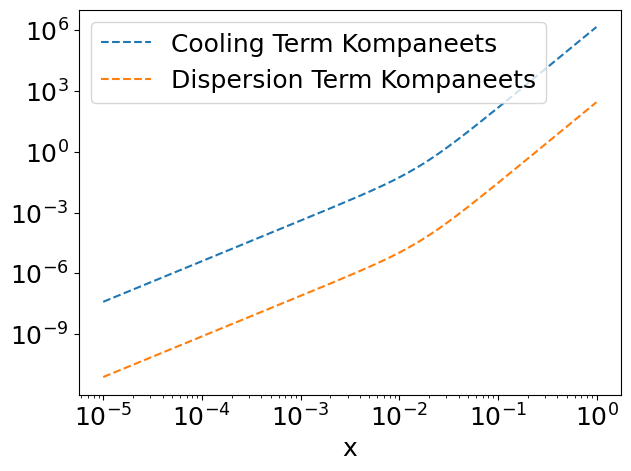

In [33]:
fig, axes= plt.subplots(1, 1, figsize = [7, 5])
ax = axes
ax.plot(sim.half_grid, sim.heating_term_kompaneets*sigma_t*sim.source_parameters['n_e']*c0/sim.half_grid**2, ls = '--', label = 'Cooling Term Kompaneets')
ax.plot(sim.half_grid, sim.dispersion_term_kompaneets*sigma_t*sim.source_parameters['n_e']*c0/sim.half_grid**2, ls = '--', label = 'Dispersion Term Kompaneets')
ax.set(xscale = 'log', yscale = 'log')
#ax.set(xlim = (1.e-6, 1.e6))
ax.legend()
ax.set(xlabel = 'x')

plt.show()

In [34]:
coolingterm_expansion_by_nu = sim.heating_term_kompaneets*sigma_t*sim.source_parameters['n_e']*c0/sim.half_grid**2
dispersionterm_expansion_by_nu =  sim.dispersion_term_kompaneets*sigma_t*sim.source_parameters['n_e']*c0/sim.half_grid**2

In [35]:
%store coolingterm_expansion_by_nu
%store dispersionterm_expansion_by_nu

Stored 'coolingterm_expansion_by_nu' (ndarray)
Stored 'dispersionterm_expansion_by_nu' (ndarray)
